# Capstone Project  - Classifying Authentic and Replica Sneakers: Book 2a

Done by: Kenny Lim, GA-DSI15

## Problem Statement

The sneaker resale market is an estimated 2 billion USD in secondary market in 2019. Estimated to be USD6 billion by 2025 according to research firm, Cowen & Co. Due to the lucrative nature of these commodities, there is the inevitable rise of counterfeits. The counterfeit sneakers sales was USD520 billion or 3.3% in global trade in 2018 and it is costing us in various ways. 

The costs to the brands include: 
1. Undercutting sales from the brands. Online counterfeit sales are responsible for approximately USD30.3 billion in annual losses to luxury brands, according to data service firm ResearchAndMarkets’ Global Brand Counterfeiting Report. 
2. Brands have to deal with the backlash from customers who have had bad experiences from fakes. Additional resources have to be allocated to deal with this
3. Reputation damage

Costs to countries:
1. US Customs and Border Protection (CBP) official stated: "However, these items often fund national and transnational criminal organizations, and cost taxpayers billions. " (Oct 2019)

Costs to collectors: 
1. We just want real sneakers man

In light of this, we want to be able to differentiate real and fake sneakers. Our task is to build a classifier that is able to differentiate between real and fake sneakers. Our primary audience will be the sneaker brands and the CBP. 

To do so, we will first be scrapping data from reddit and imgur. We will then ve using a classification model such as CNN to diffentiate between the authentic and the replicas. We will measure our success using several classification metrics including accuracy and ROCAUC. 

With this, we also hope to help buyers inform themselves and to stay away from counterfeits. Empowering the public with information, they will be able to make the right decision which could help to reduce the lucrative nature of fake sneakers. 


## Executive Summary

To combat the increasingly lucrative business of counterfeit sneakers, due to the rise of a sneaker cult following, the goal was to train a Convolutional Neural Network model to classify 2 binary outcome: Authentic or Replica sneakers.

Web scraping was performed to collect a dataset consisting of approximately 20,000 images. The [Data Scraping notebook](./book1_data_scrapping_cleaning.ipynb) can be run periodically to obtain more data over time. Eventually, we came up with a 53/47% split between authentic and replica sneakers respectively. 

As the replicas become more and more accurate to the orignals, the shade of colour and size/shape of details (logos, silhouette) on the sneakers are especially important in our case. The choice was made to maintain the RGB (coloured) and aspect ratios of the images, in the preprocessing of the images 

Our classifier was successful in predicting at an 0.84 ROCAUC score and F1 score of 0.79. We also chose the F1 score because false positive and false negatives were just as damaging to us. 

Overall, there are still areas of improvement but moving forward the first step is definitely to achieve web deployment. 

## Notebooks:
- [Data Scrapping and Cleaning](./book1_data_scrapping_cleaning.ipynb)
- [Image Selection](./book2a_img_selection.ipynb)
- [Image Preprocessing](./book2b_img_preprocessing.ipynb)
- [Modeling and Recommendations](./book3_modeling_conclusions.ipynb)

## Contents:
- [Import Libraries](#Import-Libraries)
- [Import Data](#Import-Data)
- [Image Preprocessing](#Image-Preprocessing)
- [Train Test Split](#Train-Test-Split)
- [Save Image Array Data to npy](#Save-Image-Array-Data-to-npy)

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

#image preprocessing
from PIL import Image

#visualise images
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches

#image cleaning pipeline
import os, sys, time, datetime, random
sys.path.insert(1, './yolov3')
from models import *
from utils import *

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import tensorflow as tf

## Import Data

In [2]:
#by getting img names from the download directories,
#we filter out unsuccessful downloads or corrupt images links that could cause us problems
auth_dir = '/Users/kenny/Dropbox/GA/capstone_assets/images/auth'
rep_dir = '/Users/kenny/Dropbox/GA/capstone_assets/images/rep'

#we dont want to include files such as .DS_Store
auth = [i for i in os.listdir(auth_dir) if not i.startswith('.')]
rep = [i for i in os.listdir(rep_dir) if not i.startswith('.')]

In [3]:
#combine lists
im_lst = auth + rep

In [4]:
#create labels
is_rep = ["auth" if i < len((auth)) else "rep" for i in range(len(im_lst))]

## EDA

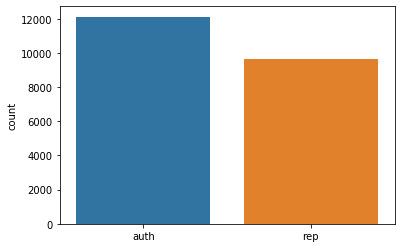

In [5]:
#let's see the data split
sns.countplot(is_rep)
plt.title('Distribution of Authentic vs Replicas');

The dataset is pretty balanced with an approximately 55/45 split between authentic and replicas respectively

In [ ]:
break

In [45]:
%%time

#let's convert and replace all files as jpeg
im_size = []

for i in range(len(im_lst)):
    try:
        temp_path = f"/Users/kenny/Dropbox/GA/capstone_assets/images/{is_rep[i]}/{im_lst[i]}"
        im = Image.open(temp_path)

        if temp_path.split('.')[-1] == 'jpg':
            im_size.append(im.size)

        else:
            im = im.convert(mode='RGB')
            im.save(temp_path.replace(".png", f".jpg"), "jpeg")
            im_size.append(im.size)
            os.remove(temp_path)

    except FileNotFoundError:
        print("FileNotFoundError")

In [48]:
im_size[0]

(3024, 3780)

In [49]:
len(im_size)

21754

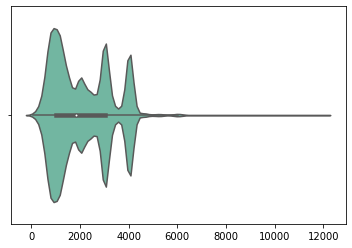

In [55]:
ax = sns.violinplot(im_size,palette="Set2")

We can see here that the size of images are generally in the 1500 x 1500 range.

## Image Cleaning Pipeline

Here we want to reduce the noise in the images and keep the object of the images centred. 
We will be utilising YOLOv3 to identify objects and crop the images. 

In [ ]:
#credit: https://github.com/cfotache/pytorch_objectdetecttrack
#this object detection pipeline is heavily referenced to the credit above. 

In [6]:
#set variables
config_path='./yolov3/config/yolov3.cfg'
weights_path='./yolov3/config/9.weights'
class_path='./yolov3/config/obj.names'
img_size=416
conf_thres=0.98                           #the detection is only included if confidence > 0.98
nms_thres=0.005                           #YOLO uses NMS to only keep the best bounding box

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cpu()                              #set this to cpu if no gpu, else cuda
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.FloatTensor               #torch.cuda.FloatTensor if gpu

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
#define detect function
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 1, conf_thres, nms_thres)
        
    return detections[0]

In [ ]:
break
#break to prevent accidentally running

In [9]:
labels =['rep']
for label in labels: 
    print(label)

rep


In [11]:
%%time

labels = ["rep"] #set(is_rep)


for label in labels:
    
    #set image paths
    #get image
    from_path = "/Users/kenny/Dropbox/GA/capstone_assets/images/{}/"        
    #save image
    to_path = "/Users/kenny/Dropbox/GA/capstone_assets/images/det/{}_det/{}"
    
    #get img names from folder
    all_imgs = [i for i in os.listdir(from_path.format(label)) if not i.startswith('.')]

    
    for i in range(len(all_imgs)):
        img_name = all_imgs[i]                                                      #assign image

        # load image and get detections
        img_org = Image.open(from_path.format(label)+img_name)                      #open image
        
        try:
            detections = detect_image(img_org)                                      #detect image

            img = np.array(img_org)                                                 #convert img to array

            #scaling and padding
            pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
            pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
            unpad_h = img_size - pad_y
            unpad_w = img_size - pad_x

            crop_lst = []                                                           #create list to store cropped images

            if detections is not None:
                # for each row in detections
                for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                    box_h = ((y2 - y1) / unpad_h) * img.shape[0]
                    box_w = ((x2 - x1) / unpad_w) * img.shape[1]
                    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
                    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

                    bbox = patches.Rectangle((x1, y1), box_w, box_h,
                                             linewidth=2, facecolor='none')

                    # crop image by bounding box
                    coords = bbox.get_bbox().get_points()                           #convert bbox to cropping coords

                    #Image.crop() takes in top-left coord (x,y) as first 2
                    #last 2 takes in right-bottom coord (x,y)
                    img_crop = img_org.crop((coords[0][0],                          #crop image
                                             coords[0][1],      
                                             coords[1][0], 
                                             coords[1][1]))

                    crop_lst.append(img_crop)                                       #append cropped image to list
            else:
                print(f"{img_name}: nothing to detect")

            #save each image to file
            for j in range(len(crop_lst)):
                crop_lst[j].save(to_path.format(label,img_name.replace(".jpg", f"-det-{j+1}.jpg"))) 
        
        except RuntimeError:
            pass
        
        except TypeError:
            pass


#credit 1: https://stackoverflow.com/questions/50306012/get-coordinates-of-the-rotated-patch-rectangle-matplotlib
#credit 2: https://stackoverflow.com/questions/39424052/how-to-set-coordinates-when-cropping-an-image-with-pil

cropped 5000 of 9632 images
Cwu3sna.jpg: nothing to detect
fHpQ7h6.jpg: nothing to detect
tVKhvdD.jpg: nothing to detect
At9QIML.jpg: nothing to detect
t8xYlKd.jpg: nothing to detect
Ww6FJ5f.jpg: nothing to detect
RypFoxH.jpg: nothing to detect
ukohyAG.jpg: nothing to detect
KIkuuPl.jpg: nothing to detect
gjdATgR.jpg: nothing to detect
xBzmAWK.jpg: nothing to detect
zPHPj7f.jpg: nothing to detect
XncSzTO.jpg: nothing to detect
SY2fgNq.jpg: nothing to detect
YrgiOX1.jpg: nothing to detect
GE4fjtA.jpg: nothing to detect
L0z9zsQ.jpg: nothing to detect
AhniNJz.jpg: nothing to detect
O8iOLPH.jpg: nothing to detect
ctA5W7q.jpg: nothing to detect
ky7kx84tlb451.jpg: nothing to detect
piYEP4Z.jpg: nothing to detect
FitVbhJ.jpg: nothing to detect
GhwuLoX.jpg: nothing to detect
s8MwyBe.jpg: nothing to detect
xl5FDuR.jpg: nothing to detect
lsNnhP7.jpg: nothing to detect
7YIbsST.jpg: nothing to detect
ADjLDwy.jpg: nothing to detect
Re4wncW.jpg: nothing to detect
vfQ725R.jpg: nothing to detect
1N5MT

BSKdzPl.jpg: nothing to detect
Kr65lbN.jpg: nothing to detect
30HCTQ3.jpg: nothing to detect
tx5uplS.jpg: nothing to detect
InfBe3k.jpg: nothing to detect
fWEiP5D.jpg: nothing to detect
6w6KZCz.jpg: nothing to detect
i9cTLpt.jpg: nothing to detect
n1ZdzSa.jpg: nothing to detect
ofHUlsS.jpg: nothing to detect
z3VYUYc.jpg: nothing to detect
5x9bq4f.jpg: nothing to detect
YXEDUjx.jpg: nothing to detect
Ftejl2s.jpg: nothing to detect
Aqlr164.jpg: nothing to detect
R6c3ZRY.jpg: nothing to detect
dsu9CFZ.jpg: nothing to detect
B6pp3Pp.jpg: nothing to detect
KtC95gm.jpg: nothing to detect
uPJrh51.jpg: nothing to detect
aect8jG.jpg: nothing to detect
Wloa3lY.jpg: nothing to detect
pLOZCKz.jpg: nothing to detect
K5T4cvQ.jpg: nothing to detect
r0IfYZj.jpg: nothing to detect
a1w1c9B.jpg: nothing to detect
whZmfxj.jpg: nothing to detect
mK91mZd.jpg: nothing to detect
oO3bwoM.jpg: nothing to detect
NIv4Oyt.jpg: nothing to detect
yLKokkj.jpg: nothing to detect
rKrQthZ.jpg: nothing to detect
CAyQ1Zw.

g3jp1hwxay951.jpg: nothing to detect
ND86Us7.jpg: nothing to detect
6FFYmgV.jpg: nothing to detect
3OB2bb4.jpg: nothing to detect
YDlUEPj.jpg: nothing to detect
VIi5nFZ.jpg: nothing to detect
sfh0F2D.jpg: nothing to detect
wr989gtokw551.jpg: nothing to detect
PcTkUSL.jpg: nothing to detect
fQn99K2.jpg: nothing to detect
lvunL52.jpg: nothing to detect
3KSO50I.jpg: nothing to detect
FhxMX0u.jpg: nothing to detect
0MivsLe.jpg: nothing to detect
dU5480J.jpg: nothing to detect
Cf0DGGr.jpg: nothing to detect
8XwK7qO.jpg: nothing to detect
I5WM4m6.jpg: nothing to detect
ltkD6Wj.jpg: nothing to detect
Y85Wp7a.jpg: nothing to detect
vluO5WO.jpg: nothing to detect
7jHNqAe.jpg: nothing to detect
Szv6ba1.jpg: nothing to detect
c1b0yqE.jpg: nothing to detect
dWc9mai.jpg: nothing to detect
rIc9XvU.jpg: nothing to detect
CsDDxpQ.jpg: nothing to detect
qy9s5Tp.jpg: nothing to detect
cACchtq.jpg: nothing to detect
hXs3di8.jpg: nothing to detect
t0WsK2X.jpg: nothing to detect
O9kYgEe.jpg: nothing to det

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


C9pGZnx.jpg: nothing to detect
GJImQog.jpg: nothing to detect
1snFvCd.jpg: nothing to detect
SvZPGoC.jpg: nothing to detect
wGnnWKs.jpg: nothing to detect
egOjqs6.jpg: nothing to detect
o3PNXIf.jpg: nothing to detect
THdXxi3.jpg: nothing to detect
azHzvyx.jpg: nothing to detect
mO4Goef.jpg: nothing to detect
TQ2g9Cp.jpg: nothing to detect
xISFtlA.jpg: nothing to detect
P6pVB3X.jpg: nothing to detect
4o7kyEE.jpg: nothing to detect
pdAbyZG.jpg: nothing to detect
SmKdPBY.jpg: nothing to detect
mHUGjkR.jpg: nothing to detect
j7dl5Lf.jpg: nothing to detect
zsE5asC.jpg: nothing to detect
MzfhAid.jpg: nothing to detect
0DhM6pn.jpg: nothing to detect
2S1nCM5.jpg: nothing to detect
8TwCfEG.jpg: nothing to detect
DAnvGe0.jpg: nothing to detect
dWDOMCx.jpg: nothing to detect
iiHXDYZ.jpg: nothing to detect
FlL4mhr.jpg: nothing to detect
I2NUA3m.jpg: nothing to detect
c28nVAH.jpg: nothing to detect
R4Ly9NA.jpg: nothing to detect
c9Y3bTc.jpg: nothing to detect
DzRaKMa.jpg: nothing to detect
JyAKdYT.

ABhjVto.jpg: nothing to detect
ttXJLB0.jpg: nothing to detect
pEPSubj.jpg: nothing to detect
ODXQa96.jpg: nothing to detect
e8TgXnA.jpg: nothing to detect
Y7OokeP.jpg: nothing to detect
FEgbhdm.jpg: nothing to detect
kumpOvC.jpg: nothing to detect
OtoD846.jpg: nothing to detect
JWKQxuk.jpg: nothing to detect
nQ2YhuO.jpg: nothing to detect
HbyYWmU.jpg: nothing to detect
dOQv0Zs.jpg: nothing to detect
Igfk5Rl.jpg: nothing to detect
9jvumfr.jpg: nothing to detect
dVd3wg5.jpg: nothing to detect
dcCEt4c.jpg: nothing to detect
5M6NLS7.jpg: nothing to detect
Gcz0atk.jpg: nothing to detect
lOXQiB4.jpg: nothing to detect
PLzmb0P.jpg: nothing to detect
dvfizmY.jpg: nothing to detect
GT6zLMm.jpg: nothing to detect
Z7ocTjd.jpg: nothing to detect
5HI0s6S.jpg: nothing to detect
eondw5c.jpg: nothing to detect
EKI4ysC.jpg: nothing to detect
bwC3FM2.jpg: nothing to detect
FiNbOr5.jpg: nothing to detect
nCrNuBb.jpg: nothing to detect
FnZGhE6.jpg: nothing to detect
y7AkOsv.jpg: nothing to detect
TItiJvM.

dddug5W.jpg: nothing to detect
f3N4LCW.jpg: nothing to detect
KooF6yT.jpg: nothing to detect
KFu38Ls.jpg: nothing to detect
gKt03xd.jpg: nothing to detect
h3aDFij.jpg: nothing to detect
jiCFB2z.jpg: nothing to detect
xnQY2RH.jpg: nothing to detect
ZSpXcuN.jpg: nothing to detect
SswPU7B.jpg: nothing to detect
weGPwzS.jpg: nothing to detect
pQQqXw1.jpg: nothing to detect
NzrfE8N.jpg: nothing to detect
lJo4uXz.jpg: nothing to detect
Fy1vcPt.jpg: nothing to detect
DTy1AxF.jpg: nothing to detect
eYkUsME.jpg: nothing to detect
LgMNnH3.jpg: nothing to detect
dzvcuwc.jpg: nothing to detect
fj7QQuw.jpg: nothing to detect
cropped 7500 of 9632 images
h7DJPmZ.jpg: nothing to detect
xgeiFMz.jpg: nothing to detect
mqZfI4M.jpg: nothing to detect
nwBIYkE.jpg: nothing to detect
fDxCViC.jpg: nothing to detect
GjD87Qq.jpg: nothing to detect
BCr8I7o.jpg: nothing to detect
TxGJYST.jpg: nothing to detect
COn7D94.jpg: nothing to detect
gCoKqWD.jpg: nothing to detect
NoOvf6C.jpg: nothing to detect
luHc3Qb.jpg

gZS6NW8.jpg: nothing to detect
1VnvI9m.jpg: nothing to detect
qTdSbzo.jpg: nothing to detect
98QYM5p.jpg: nothing to detect
zU4l6Ek.jpg: nothing to detect
hmSzcCS.jpg: nothing to detect
ttORKKy.jpg: nothing to detect
vP8Y9T6.jpg: nothing to detect
XvMTcq4.jpg: nothing to detect
j3jBVIy.jpg: nothing to detect
zTBNYGa.jpg: nothing to detect
g29O9zn.jpg: nothing to detect
XYuUgXt.jpg: nothing to detect
MXAV7TF.jpg: nothing to detect
HO8nKNY.jpg: nothing to detect
YFtDpfG.jpg: nothing to detect
0a2Ei8r.jpg: nothing to detect
8K5C3QB.jpg: nothing to detect
SUCzZit.jpg: nothing to detect
lS6UkTW.jpg: nothing to detect
qhKzlck.jpg: nothing to detect
oC0l66V.jpg: nothing to detect
9IEz8r7.jpg: nothing to detect
UE5tLGq.jpg: nothing to detect
gA136v1.jpg: nothing to detect
iuDH3GD.jpg: nothing to detect
9PBqhWu.jpg: nothing to detect
WiEGzCg.jpg: nothing to detect
vgJAZKi.jpg: nothing to detect
XWRKE7e.jpg: nothing to detect
UMSd78B.jpg: nothing to detect
skVpSkp.jpg: nothing to detect
G5KCGSW.

7xb0I8O.jpg: nothing to detect
qLAeinL.jpg: nothing to detect
PoK13pu.jpg: nothing to detect
KrmTCgF.jpg: nothing to detect
pBOclCO.jpg: nothing to detect
km8exGc.jpg: nothing to detect
poSmx4T.jpg: nothing to detect
wwVCc4Y.jpg: nothing to detect
HnrtVhQ.jpg: nothing to detect
igHF36k.jpg: nothing to detect
Wc3ShaZ.jpg: nothing to detect
Lvgh45h.jpg: nothing to detect
AtjyX3K.jpg: nothing to detect
etsWgUu.jpg: nothing to detect
tPia3gV.jpg: nothing to detect
mMbMmfi.jpg: nothing to detect
vy2Fj5V.jpg: nothing to detect
ESqKMfz.jpg: nothing to detect
ui5YHPW.jpg: nothing to detect
90dnG8N.jpg: nothing to detect
nCpE99g.jpg: nothing to detect
6q5JI6S.jpg: nothing to detect
esXxvSg.jpg: nothing to detect
hkSNbMn.jpg: nothing to detect
pOyJfvX.jpg: nothing to detect
JGu09s8.jpg: nothing to detect
5W9s8U1.jpg: nothing to detect
TYhAYco.jpg: nothing to detect
hxHDpCD.jpg: nothing to detect
XhKR1yI.jpg: nothing to detect
7JnltEC.jpg: nothing to detect
mK5YEP7.jpg: nothing to detect
8aaDjdb.

QGCsKIK.jpg: nothing to detect
kfNnDeh.jpg: nothing to detect
nB542vd.jpg: nothing to detect
Kmf8K3t.jpg: nothing to detect
sXUKYvN.jpg: nothing to detect
F36q8bC.jpg: nothing to detect
ORKvnZq.jpg: nothing to detect
JM24QpX.jpg: nothing to detect
iGV2Re4.jpg: nothing to detect
sry72hM.jpg: nothing to detect
BiE7PAs.jpg: nothing to detect
LYqi8Yn.jpg: nothing to detect
OFAYchP.jpg: nothing to detect
BtcbYRv.jpg: nothing to detect
hFqXwWk.jpg: nothing to detect
RlRUbi6.jpg: nothing to detect
31pw7s2.jpg: nothing to detect
x4DNUiV.jpg: nothing to detect
zgg7xk6.jpg: nothing to detect
yXY1Iq8.jpg: nothing to detect
Bj3eV4h.jpg: nothing to detect
ovLTxOm.jpg: nothing to detect
1oOmJEE.jpg: nothing to detect
DSQ4mru.jpg: nothing to detect
3Tg0nJu.jpg: nothing to detect
59EiYEI.jpg: nothing to detect
oiaBEct.jpg: nothing to detect
3cI6k3l.jpg: nothing to detect
Sp0V6LK.jpg: nothing to detect
9sj3WaC.jpg: nothing to detect
xMaIZJA.jpg: nothing to detect
bSI3VFB.jpg: nothing to detect
7KDnG5I.